Data preparation for CBOW

In [2]:
# Import librairies

import re
import nltk
import numpy as np
from utils2 import *


nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
# Define tokenize function

def tokenize(sentence) : 
  """
  Tokenize a sentence
  Input : 
    sentence : string
  Output : 
    sentence : list of tokenized sentence
  """
  sentence =  nltk.word_tokenize(re.sub(r'[,!?.]', '.', sentence), language = "french")
  sentence_tokenized = [token.lower() for token in sentence
              if token.isalpha()
              or token == "."]

  return sentence_tokenized


In [4]:
def get_windows(words, C) :
  """
  For a word in words, give context word if possible
  Input : 
    words : tokenized sentence
    C : number of context word at left and at right
  Output : 
    center a word and his context words
  
  """
  i = C

  while i < len(words) - C : 
    center_word = words[i]
    context_word = words[(i-C) : i] + words[(i + 1) : (i + C + 1) ]

    yield center_word, context_word 
    i += 1


In [61]:
#Create function witch upload  a dataset and give word and in context for a given word.

def upload_data(filename) : 

  """
  1 Import file
  2 Read by line
  3 tokenization
  4 Storage in a list
  """
  tokenize_l = []
  # Import file
  file = open(filename, 'r').read()
  # Split by "\n"
  file = file.split("\n")

  # Loop for tokenizing sentence
  for line in file : 
    tokenized_line = tokenize(line)
    if tokenized_line : 
      tokenize_l.extend(tokenize(line))
  return tokenize_l

# Upload text
f = upload_data("test.txt")

print(f[:10])


['numberly', 'aide', 'ses', 'clients', 'à', 'collecter', '.', 'analyser', 'et', 'mettre']


In [62]:
# Create a vocabulary
# Create a dictionary where keys are word and value its index
# Create a dictionary where keys are index and value its word

def get_dict(corpus) : 
  """
  1 create a temporary liste of unique words in a corpus
  2 give a number to each word
  3 create the 2 dictionary
  Input : corpus like a list of tokenized sentence
  Output : 
    word2ind : dictionary which have word in key and indice of word in value 
    ind2word : dictionary which have indice in key and word in value
    vocabulary : a list of unique words
  """

  vocab = sorted(set(corpus))
  # word2ind
  word2ind = {word : i for i, word in enumerate(vocab)}
  # ind2word
  ind2word = {i : word for i, word in enumerate(vocab)}

  return word2ind, ind2word

word2ind, ind2word = get_dict(f)
print(len(word2ind), len(ind2word))

642 642


In [8]:
#Get one-hot vector from words

def get_one_hot_vector(word, word2ind, size) : 
  """
  Input : 
    context_words : list of context words
    word2ind : dictionary which have word in key and indice of word in value
    size = dimension of word embedding
  Output : 
    one hot vector 
  """
  # Initialize matrix
  vec = np.zeros(size)
  
  if word in word2ind.keys() : 
    vec[word2ind[word]] = 1
   
  return(vec)

In [9]:
# Get context vectors
def get_context_vectors(context_words, word2ind, size) : 
  """
  Input : 
    context_words : list of context words
    word2ind : dictionary which have word in key and indice of word in value
    size = dimension of word embedding
  Output : 
    context vector 
  """
  return np.mean([get_one_hot_vector(word, word2ind, size) for word in context_words], axis = 0)


In [10]:
def get_training_example(words, word2ind,  size, C = 2) :
  """
  For words give for each center word, its one hot and its context vectors
  """

  for center_word, context_words in get_windows(words, C) : 
    
    yield get_one_hot_vector(center_word, word2ind, size), get_context_vectors(context_words, word2ind, size)
  

In [ ]:
# We have our 2 sets for computing CBOW. 

Continuous Bag of Word Model

In [12]:
# Definition of functions used for modelisation

def relu(z) : 
  if type(z) != np.ndarray :
    z = np.array(z)
  z[z<0] = 0
  return z

def softmax(z) : 
  if type(z) != np.ndarray :
   z = np.array(z)
  exp_z = np.exp(z)
  sum_exp_z = np.sum(exp_z)
  return exp_z/sum_exp_z

# Test softmax function
softmax([-4, 1,4])

array([3.19450938e-04, 4.74107229e-02, 9.52269826e-01])

In [71]:
# Initialize model

def initialize_model(N, V, random_seed = 0): 
  """ 
  Input : 
      N : size of hidden layer
      V : length of vocabulary
  Output : 
    W : dictionary of Weights W1 and W2
    b : dictionary of biais b1 and b2
  """
  # Set seed
  np.random.seed(random_seed)

  # Initialize W1
  W1 = np.random.rand(N*V).reshape(N,V)
  
  # Initialize b1
  b1 = np.random.rand(N).reshape(N,-1)
  
  # Initialize W2
  W2 = np.random.rand(N*V).reshape(V,N)

  # Initialize 2 
  b2 = np.random.rand(V).reshape(V,-1)

  return W1, W2, b1, b2


In [16]:

def forward_prop(x, W1, W2, b1, b2):
    '''
    Inputs: 
        x:  average one hot vector for the context 
        W1, W2, b1, b2:  matrices and biases to be learned
     Outputs: 
        z:  output score vector
    '''
    
    ### START CODE HERE (Replace instances of 'None' with your own code) ###
    
    # Calculate h
    h = np.dot(W1, x) + b1
    
    # Apply the relu on h (store result in h)
    h = relu(h)
    
    # Calculate z
    z = np.dot(W2, h) + b2
    
    ### END CODE HERE ###

    return z, h

In [17]:
# Back propagation

def back_prop(x, y_hat, y, h, W1, W2, b1, b2, batch_size) :

  '''
  Inputs: 
      x:  average one hot vector for the context 
      yhat: prediction (estimate of y)
      y:  target vector
      h:  hidden vector (see eq. 1)
      W1, W2, b1, b2:  matrices and biases  
      batch_size: batch size 
    Outputs: 
      grad_W1, grad_W2, grad_b1, grad_b2:  gradients of matrices and biases   
  '''

  l1 = relu(np.dot(W2.T, (y_hat - y)))

  # Compute the gradient of W1
  grad_W1 = np.dot(l1, x.T)

  # Compute the gradient of W2
  grad_W2 = np.dot((y_hat - y), h.T)

  # Compute the gradient of b1
  grad_b1 = np.sum(l1, axis = 1, keepdims=True)/batch_size
  
  # Compute the gradient of b2
  grad_b2 = np.sum((y_hat - y), axis = 1, keepdims = True)/batch_size

  return W1, W2, b1, b2

In [72]:
# compute_cost: cross-entropy cost functioN
def compute_cost(y, yhat, batch_size):
    # cost function 
    logprobs = np.multiply(np.log(yhat),y) + np.multiply(np.log(1 - yhat), 1 - y)
    cost = - 1/batch_size * np.sum(logprobs)
    cost = np.squeeze(cost)
    return cost
  
# Cross entropy
def cross_entropy_loss(y_hat, y):

  loss = np.sum(-np.log(y_hat)*y)/len(y)

  return loss
cross_entropy_loss(y_hat, y)

0.5122282727130949

In [22]:

def gradient_descent(data, word2Ind, N, V, num_iters, alpha=0.03):
    
  '''
  This is the gradient_descent function
  
    Inputs: 
      data:      text
      word2Ind:  words to Indices
      N:         dimension of hidden vector  
      V:         dimension of vocabulary 
      num_iters: number of iterations  
    Outputs: 
      W1, W2, b1, b2:  updated matrices and biases   

  '''
  W1, W2, b1, b2 = initialize_model(N,V, random_seed=282)
  batch_size = 128
  iters = 0
  C = 2
  for x, y in get_batches(data, word2Ind, V, C, batch_size):

      # Get z and h
      z, h = forward_prop(x, W1, W2, b1, b2)

      # Get yhat
      yhat = softmax(z)

      # Get cost
      cost = compute_cost(y, yhat, batch_size)
      if ( (iters+1) % 10 == 0):
          print(f"iters: {iters + 1} cost: {cost:.6f}")
          
      # Get gradients
      grad_W1, grad_W2, grad_b1, grad_b2 = back_prop(x, yhat, y, h, W1, W2, b1, b2, batch_size)
      
      # Update weights and biases
      W1 = W1 - alpha * grad_W1 
      W2 = W2 - alpha * grad_W2
      b1 = b1 - alpha * grad_b1
      b2 = b2 - alpha * grad_b2
      
      ### END CODE HERE ###
      
      iters += 1 
      if iters == num_iters: 
          break
      if iters % 100 == 0:
          alpha *= 0.66
          
  return W1, W2, b1, b2

In [67]:
# test your function
C = 2
N = 50
word2Ind, Ind2word = get_dict(f)
V = len(word2Ind)
print(V)
num_iters = 150
print("Call gradient_descent")
W1, W2, b1, b2 = gradient_descent(f, word2Ind, N, V, num_iters)

642
Call gradient_descent
iters: 10 cost: 11.485822
iters: 20 cost: 11.279810
iters: 30 cost: 11.279304
iters: 40 cost: 11.308265
iters: 50 cost: 11.329036
iters: 60 cost: 11.338994
iters: 70 cost: 11.341899
iters: 80 cost: 11.341168
iters: 90 cost: 11.338929
iters: 100 cost: 11.336311
iters: 110 cost: 11.334573
iters: 120 cost: 11.333063
iters: 130 cost: 11.331718
iters: 140 cost: 11.330544
iters: 150 cost: 11.329533


In [64]:
# We can get word embedding from columns of matrix of weights W1. For example the embedding of word to the first indices is : 
indice = 1
print(ind2word[indice])
print()
print("The embedding of word {} are {}".format(ind2word[indice], W1[:,indice]))


acceptez

The embedding of word acceptez are [6.85309413e-03 4.65330243e-03 1.63023251e-02 1.58029527e-02
 1.67314198e-02 1.07483169e-03 1.20410305e-02 8.04831063e-03
 5.80444443e-03 9.67911222e-03 5.84495617e-03 5.66849971e-03
 1.08434593e-04 3.73289452e-03 1.71801527e-02 6.34377197e-03
 7.01554319e-03 5.41482484e-03 6.72697130e-03 1.52933243e-02
 2.92263535e-05 7.36884986e-03 2.70631899e-03 1.28997728e-02
 8.48618531e-03 1.02672019e-02 3.99995310e-03 1.30955728e-02
 1.66801730e-03 5.18420649e-03 7.43941159e-03 1.67910675e-02
 5.31569609e-03 1.08203418e-02 3.75455248e-03 9.97789582e-03
 1.37296948e-03 1.30139092e-02 1.52450247e-02 1.20977102e-02
 1.05900308e-02 1.62972130e-02 1.64352611e-03 4.00535765e-03
 2.86697444e-03 2.06723759e-03 1.29749405e-03 1.55095156e-02
 1.65617317e-02 6.88603653e-03]


In [30]:
def compute_pca(data, n_components=2):
    """
    Input: 
        data: of dimension (m,n) where each row corresponds to a word vector
        n_components: Number of components you want to keep.
    Output: 
        X_reduced: data transformed in 2 dims/columns + regenerated original data
    pass in: data as 2D NumPy array
    """

    m, n = data.shape

    # mean center the data
    data -= data.mean(axis=0)

    # calculate the covariance matrix
    R = np.cov(data, rowvar=False)

    # calculate eigenvectors & eigenvalues of the covariance matrix
    evals, evecs = linalg.eigh(R)

    # sort eigenvalue in decreasing order
    # this returns the corresponding indices of evals and evecs
    idx = np.argsort(evals)[::-1]
    evecs = evecs[:, idx]
    
    # sort eigenvectors according to same index
    evals = evals[idx]

    # select the first n eigenvectors 
    evecs = evecs[:, :n_components]

    return np.dot(evecs.T, data.T).T

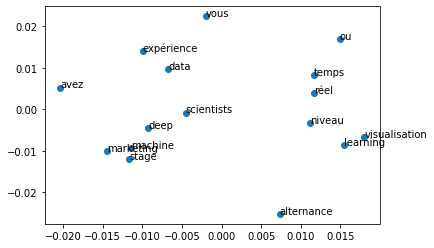

In [69]:
import matplotlib.pyplot as plt

names = tokenize("data scientists temps réel marketing visualisation stage ou alternance Vous avez niveau expérience deep learning machine")
indices = [word2ind[word] for word in names]

X = W1[:,indices]

result= compute_pca(X.T, 2)
plt.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(names):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()